In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as rnd
from scipy.stats import norm
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from skimage import io
from PIL import Image
from io import BytesIO
import requests
from skimage.util import view_as_windows
from stepmix.stepmix import StepMix
from scipy.stats import wasserstein_distance

In [16]:
# Importation des données
star_data = pd.read_csv ('data_star.csv')
classes_categ = star_data['Star category'].unique()

star_data.replace({'Spectral Class':{'M':0, 'A':1, 'B':2, 'F':1, 'O':2, 'K':0, 'G':1 }}, inplace = True)
star_data_model = star_data.drop(columns = ['Star type'])

star_data_model['Star color'], _ = pd.factorize(star_data_model['Star color'])
star_data_model["Radius (R/Ro)"] = np.log(star_data_model["Radius (R/Ro)"])
star_data_model["Luminosity (L/Lo)"] = np.log(star_data_model["Luminosity (L/Lo)"])

/var/folders/vv/yd9tg_vd01b85m5mbpmc1v3r0000gn/T/ipykernel_87294/4060156594.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  star_data.replace({'Spectral Class':{'M':0, 'A':1, 'B':2, 'F':1, 'O':2, 'K':0, 'G':1 }}, inplace = True)


In [51]:
for categ in classes_categ:
    star_data_categ = star_data_model.loc[star_data_model['Star category'] == categ]
    star_data_categ = star_data_categ.drop(columns = ['Star category'])
    std_values = star_data_categ.std()
    std_values = std_values.replace(0, 1)
    star_data_categ = star_data_categ / std_values

    GMM_star_categ = GaussianMixture(n_components = 1, covariance_type='full', init_params = 'random_from_data')
    GMM_star_categ.fit(star_data_categ)

    means = GMM_star_categ.means_
    covariances = GMM_star_categ.covariances_
    normal_sample = np.random.multivariate_normal(means[0], covariances[0], len(star_data_categ))

    wasserstein_distances = [
    wasserstein_distance(star_data_categ.iloc[:, i], normal_sample[:, i])
    for i in range(star_data_categ.shape[1])
    ]

    avg_wasserstein = np.mean(wasserstein_distances)
    print("Pour :", categ)
    print(f"Distance de Wasserstein: {avg_wasserstein:.4f}")



Pour : Brown Dwarf
Distance de Wasserstein: 0.1470
Pour : Red Dwarf
Distance de Wasserstein: 0.1244
Pour : White Dwarf
Distance de Wasserstein: 0.3132
Pour : Main Sequence
Distance de Wasserstein: 0.3526
Pour : Supergiant
Distance de Wasserstein: 0.3888
Pour : Hypergiant
Distance de Wasserstein: 0.3754


/var/folders/vv/yd9tg_vd01b85m5mbpmc1v3r0000gn/T/ipykernel_87294/2888304882.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


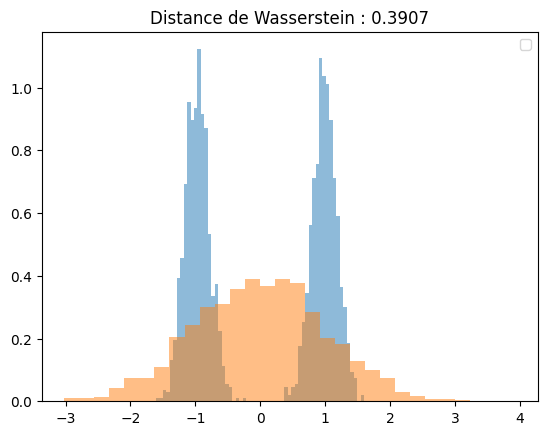

Distance de Wasserstein entre la mixture et la normale de comparaison : 0.3907


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

# Génération des deux gaussiennes séparées
np.random.seed(42)  # Reproductibilité
n_samples = 1000

mu1, sigma1 = -5, 1  # Première gaussienne
mu2, sigma2 = 5, 1  # Deuxième gaussienne

# Mélange des deux gaussiennes (50% pour chaque)
data1 = np.random.normal(mu1, sigma1, n_samples)
data2 = np.random.normal(mu2, sigma2, n_samples)

# Créer une mixture de gaussiennes en les combinant
mixture_data = np.concatenate([data1, data2])
std = np.sqrt(np.var(mixture_data))
mixture_data = mixture_data/std

# Nouvelle distribution normale à comparer avec la mixture
mu_comparaison = (mu1 + mu2)/2  # Moyenne de la loi normale à comparer
sigma_comparaison = 1  # Écart-type de la loi normale à comparer
comparaison_data = np.random.normal(mu_comparaison, sigma_comparaison, len(mixture_data))

# Calcul de la distance de Wasserstein entre la mixture et la nouvelle normale
dist_w = wasserstein_distance(mixture_data, comparaison_data)

# Affichage des distributions
plt.hist(mixture_data, bins=60, alpha=0.5, density=True)
plt.hist(comparaison_data, bins=30, alpha=0.5, density=True)
plt.legend()
plt.title(f"Distance de Wasserstein : {dist_w:.4f}")
plt.show()

print(f"Distance de Wasserstein entre la mixture et la normale de comparaison : {dist_w:.4f}")


Distance de Wasserstein entre la loi uniforme et la loi gaussienne : 0.2735330731475124


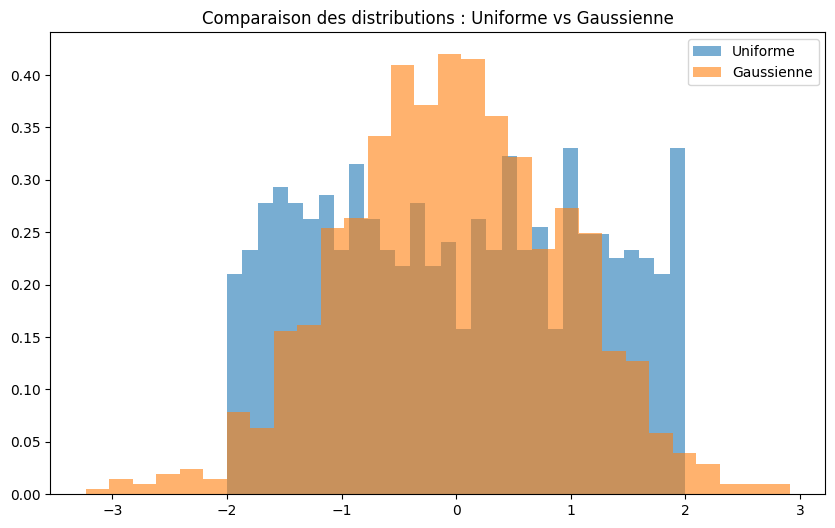

In [46]:
import numpy as np
from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt

# Paramètres
n = 1000  # nombre d'échantillons
mean, std = 0, 1  # Moyenne et écart type pour la distribution gaussienne
low, high = -2, 2  # Limites pour la distribution uniforme

# Générer les échantillons
uniform_samples = uniform.rvs(loc=low, scale=high - low, size=n)
gaussian_samples = norm.rvs(loc=mean, scale=std, size=n)

# Calculer la distance de Wasserstein
distance = wasserstein_distance(uniform_samples, gaussian_samples)

# Affichage
print(f"Distance de Wasserstein entre la loi uniforme et la loi gaussienne : {distance}")

# Optionnel: afficher les distributions
plt.figure(figsize=(10, 6))
plt.hist(uniform_samples, bins=30, alpha=0.6, label='Uniforme', density=True)
plt.hist(gaussian_samples, bins=30, alpha=0.6, label='Gaussienne', density=True)
plt.legend()
plt.title("Comparaison des distributions : Uniforme vs Gaussienne")
plt.show()
